# XRD Analysis

## Raw Data

,two_theta,intensity
0,10.83,3985.0
1,10.84,3855.0
2,10.85,4110.0
3,10.86,4210.0
4,10.87,4105.0


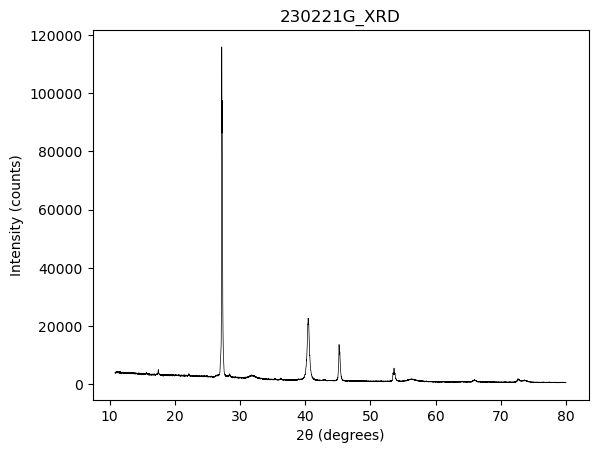

In [22]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy import sparse
from scipy.sparse.linalg import spsolve
from lmfit import Model
from lmfit.models import PseudoVoigtModel
from scipy.optimize import curve_fit
import scipy.special
from IPython.display import display
import ipywidgets as widgets
import re

Cu_wl = 15.406 #Copper K-alpha wavelnegth in nm

# Enable interactive plots in Jupyter Notebook
%matplotlib inline

# Set the path to the foldercontaining text files
folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\XRD\\230221G"
file_name = "230221G_XRD.xy"
file_title = file_name.replace('.xy', '')

# Read the data from the text file, skipping the first lines
df = pd.read_csv(os.path.join(folder_path, file_name), sep=" ", skiprows=800, header=None, names=["two_theta", "intensity"])

# Load the XRD reference pattern from Excel
reference_path = 'C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\XRD\\XRD ref patterns.xlsx'
CZTSe_reference_df = pd.read_excel(reference_path, sheet_name='CZTSe')
CZTS_reference_df = pd.read_excel(reference_path, sheet_name='CZTS')
MoSe2_reference_df = pd.read_excel(reference_path, sheet_name='MoSe2')
Mo_reference_df = pd.read_excel(reference_path, sheet_name='Mo')

CZTSe_reference_df = CZTSe_reference_df.rename(columns={CZTSe_reference_df.columns[0]: 'Two Theta', CZTSe_reference_df.columns[1]: 'Intensity'})
CZTS_reference_df = CZTS_reference_df.rename(columns={CZTS_reference_df.columns[0]: 'Two Theta', CZTS_reference_df.columns[1]: 'Intensity'})
MoSe2_reference_df = MoSe2_reference_df.rename(columns={MoSe2_reference_df.columns[0]: 'Two Theta', MoSe2_reference_df.columns[1]: 'Intensity'})
Mo_reference_df = Mo_reference_df.rename(columns={Mo_reference_df.columns[0]: 'Two Theta', Mo_reference_df.columns[1]: 'Intensity'})

# List of reference patterns to include
refs = [
    CZTSe_reference_df, 
        Mo_reference_df,
       CZTS_reference_df,
       MoSe2_reference_df
       ] 

# Create a simple line plot of the XRD raw data
plt.plot(df["two_theta"], df["intensity"], linewidth=0.5, c='k')
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (counts)")
plt.title(file_title)

# View the first few rows of the DataFrame
df.head()

## Baseline Removal, Normalise Intensity, Peak Removal

C:\Users\w16025698\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\w16025698\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,two_theta,intensity,baseline,baseline subtracted data,normalised intensity,log data,SQRT data,peak_position
0,10.83,3985.0,3679.377397,305.622603,0.269230,5.722351,17.482065,NaN
1,10.84,3855.0,3678.336006,176.663994,0.155627,5.174250,13.291501,NaN
2,10.85,4110.0,3677.294616,432.705384,0.381180,6.070057,20.801572,NaN
3,10.86,4210.0,3676.253226,533.746774,0.470190,6.279922,23.102960,NaN
4,10.87,4105.0,3675.211836,429.788164,0.378610,6.063292,20.731333,NaN
...,...,...,...,...,...,...,...,...
6913,79.96,655.0,494.248090,160.751910,0.141610,5.079862,12.678798,NaN
6914,79.97,585.0,494.080377,90.919623,0.080093,4.509976,9.535178,NaN
6915,79.98,535.0,493.912663,41.087337,0.036195,3.715700,6.409940,NaN
6916,79.99,585.0,493.744950,91.255050,0.080389,4.513658,9.552751,NaN


<Figure size 640x480 with 0 Axes>

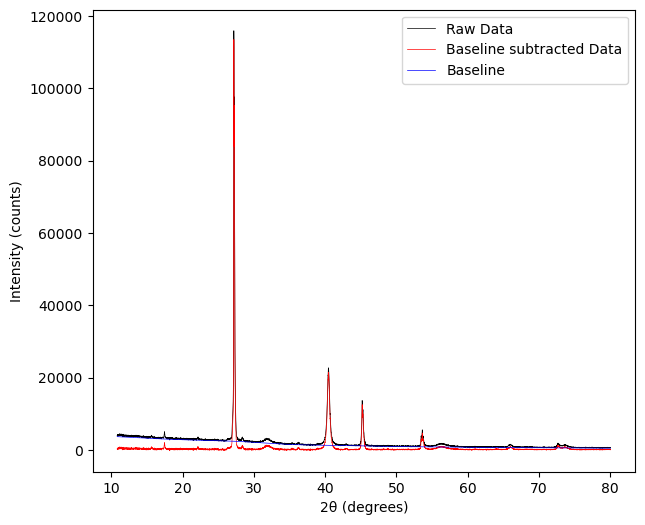

In [28]:
def baseline_als(y, lam, p, niter=10):
    '''
    "Asymmetric Least Squares Smoothing Algorithm" - P. Eilers and H. Boelens, 2005
    
    <<There are two parameters: p for asymmetry and λ for smoothness. 
    Both have to be tuned to the data at hand. 
    We found that generally 0.001 ≤ p ≤ 0.1 is a good choice (for a signal with positive peaks) 
    and 10^2 ≤ λ ≤ 10^9 , but exceptions may occur. 
    In any case one should vary λ on a grid that is approximately linear for log λ>>
    '''
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def normalised_intensity(x, norm_val):
    # Find the maximum intensity value in the 'base_sub_intensity' column
    max_intensity = x.max()

    # Normalize the intensity values to a maximum of 100
    normalised_data = (x / max_intensity) * norm_val

    return normalised_data

df['baseline'] = baseline_als(df['intensity'], 10E7, 0.001, niter=100)
df['baseline subtracted data'] = df['intensity'] - df['baseline']
df['normalised intensity'] = normalised_intensity(df['baseline subtracted data'], 100)
df['log data'] = np.log(df['baseline subtracted data'])
df['SQRT data'] = np.sqrt(df['baseline subtracted data'])

excel_filename = file_title + ' data.xlsx'
excel_file_path = os.path.join(folder_path, excel_filename)

with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name='raw data', index=False)

plt.clf()
fig = plt.subplots(figsize=(7, 6))
plt.plot(df["two_theta"], df['intensity'], label='Raw Data', c='k', linewidth=0.5)
plt.plot(df["two_theta"], df['baseline subtracted data'], label='Baseline subtracted Data', c='r', linewidth=0.5)
plt.plot(df["two_theta"], df['baseline'], label='Baseline', c='b', linewidth=0.5)
# plt.plot(df["two_theta"], df['normalised intensity'], label='Normalised Intensity', c='k', linewidth=0.5)
# plt.xlim(40,41)
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (counts)")
plt.legend()

display(df)

,two_theta,intensity,baseline,baseline subtracted data,normalised intensity,log data,SQRT data,peak_position
0,10.83,3985.0,3679.377397,305.622603,0.269230,5.722351,17.482065,NaN
1,10.84,3855.0,3678.336006,176.663994,0.155627,5.174250,13.291501,NaN
2,10.85,4110.0,3677.294616,432.705384,0.381180,6.070057,20.801572,NaN
3,10.86,4210.0,3676.253226,533.746774,0.470190,6.279922,23.102960,NaN
4,10.87,4105.0,3675.211836,429.788164,0.378610,6.063292,20.731333,NaN
...,...,...,...,...,...,...,...,...
6913,79.96,655.0,494.248090,160.751910,0.141610,5.079862,12.678798,NaN
6914,79.97,585.0,494.080377,90.919623,0.080093,4.509976,9.535178,NaN
6915,79.98,535.0,493.912663,41.087337,0.036195,3.715700,6.409940,NaN
6916,79.99,585.0,493.744950,91.255050,0.080389,4.513658,9.552751,NaN


<Figure size 640x480 with 0 Axes>

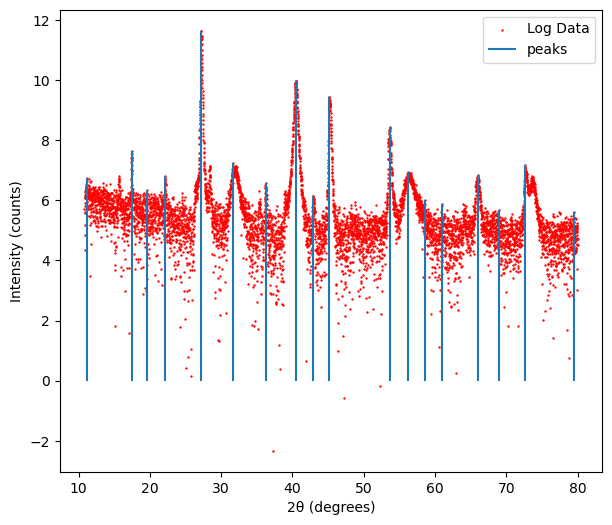

In [27]:
# Find peaks in the baseline-subtracted data
peaks, _ = find_peaks(df['log data'], prominence=2, distance=200)  # Selenised

# Add a column to the DataFrame indicating peak positions
df['peak_position'] = np.nan
df.loc[peaks, 'peak_position'] = df.loc[peaks, 'log data']

plt.clf()
fig = plt.subplots(figsize=(7, 6))
plt.scatter(df["two_theta"], df['log data'], label='Log Data', c='r', s=0.5)
plt.vlines(df["two_theta"], 0, df['peak_position'], label='peaks')
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity (counts)")
plt.legend()
display(df)

## Log Plot

<Figure size 640x480 with 0 Axes>

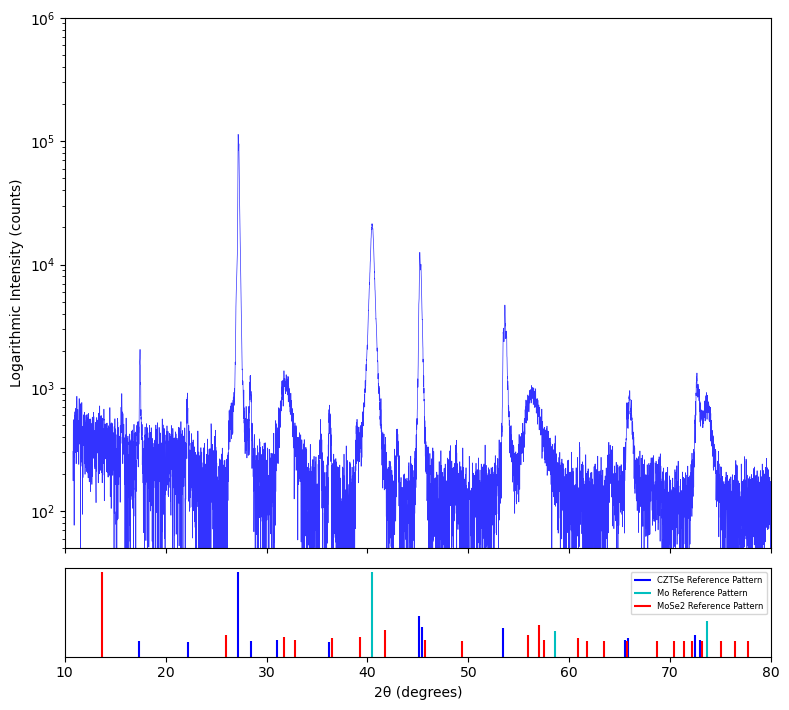

In [43]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8), gridspec_kw={'height_ratios': [6, 1]})

# Plot the sum of curves on the first subplot
# ax1.scatter(df['two_theta'], df['baseline subtracted data'], s=0.5, c='b', alpha=0.8, label='log Data')
ax1.plot(df['two_theta'], df['baseline subtracted data'], c='b', alpha=0.8, linewidth=0.5, label='log Data')
ax1.set_ylabel("Logarithmic Intensity (counts)")
# ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(10,80)
ax1.set_ylim(50E0,10E5)
ax1.set_yscale('log')

# ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
# ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='6')

# Adjust spacing between subplots and set the height of the reference subplot
plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.9])

plt.savefig(os.path.join(folder_path, 'XRD Plots', file_title + ' 25 to 37 log_plot.png'), dpi=300)

## SQRT Plot

<Figure size 640x480 with 0 Axes>

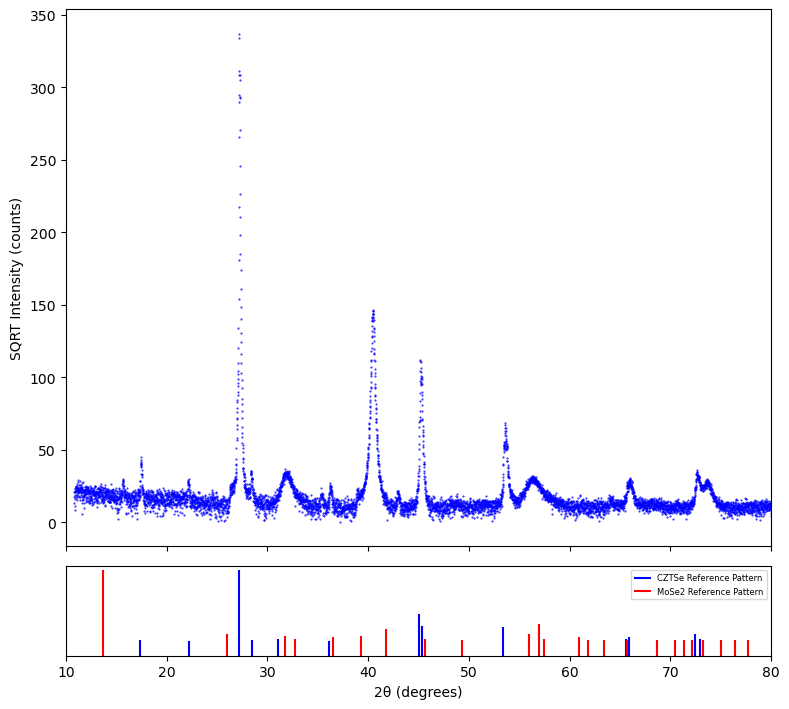

In [26]:
# Plot
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [6, 1]})

# Plot the sum of curves on the first subplot
ax1.scatter(df['two_theta'], df['SQRT data'], s=0.3, c='b', alpha=0.8, label='SQRT Data')
ax1.set_ylabel("SQRT Intensity (counts)")
# ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(10,80)
# ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
# ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
# ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='6')

# Adjust spacing between subplots and set the height of the reference subplot
plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig(os.path.join(folder_path, 'XRD Plots', file_title + ' 25 to 37 SQRT_plot.png'), dpi=300)

# Voigt Function

### _psdVoigt
$$
y=y_0+A\left[ m_u\frac 2\pi \frac{w_L}{4\left( x-x_c\right) ^2+w_L^2}+\left( 1-m_u\right) \frac{\sqrt{4\ln 2}}{\sqrt{\pi}w_G}e^{-\frac{4\ln 2}{w_G^2}\left( x-x_c\right) ^2}\right] 
$$

where
$A > 0$ : Area   
$w_G, w_L > 0$ : Gaussian FWHM, Lorentzian FWHM   
$m_u = 0.9$: profile shape factor   
$y_0$ : y-axis offset   
$x_c$ : Peak center

***
### Integral Breadth $\left( \beta
\right)$, Voigt FWHM $\left( \Gamma \right)$ & mixing parameter $\left( \eta \right)$

Calculation of integral breadth ($\beta$) by combining Gaussian FWHM $\left( \Gamma_G \right)$ and Lorentzian FWHM $\left( \Gamma_L \right)$ is mandatory in order to perform proper microstructural analysis. However, given the convolution of gaussian and Lorentzian by applying the Voigt function is mathematically complex, they are treated by the approximating psuedo-Voigt function. 

$\beta$ shows isotropic peak braodening caused by microstrain and/or small average domain size. In contrast to the FWHM $\Gamma$, the integral breadth $\beta_{sample}$ includes information on the integral intensity $I_A$, the area enveloped by the peak. Integral breadth is calculated as the ratio between the integral intensity and FWHM $\Gamma$.

$$
\Gamma_G^2 = U \cdot tan^2 \Theta_\Gamma + V \cdot \tan \Theta_\Gamma + W
$$
***
$$
\Gamma_L = X \cdot tan \Theta_\Gamma + \frac{Y}{cos \Theta_\Gamma}
$$
***
$$
\beta_{pV} = 0.5  \cdot \eta \cdot \pi \cdot \Gamma_L + (1- \eta) \cdot 0.5 \cdot \Gamma_G \cdot \sqrt{\frac{\pi}{ln(2)}}
$$
***
where Voigt width $\Gamma$ is computed as:
$$
\Gamma = \left( \Gamma_{G}^{5} + 2.69269 \Gamma_{G}^{4} \Gamma_L + 2.42843 \Gamma_{G}^{3} \Gamma_{L}^{2} + 4.47163\Gamma_{G}^{2} \Gamma_{L}^{3}+0.07842 \Gamma_{G} \Gamma^{4}_{L}+ \Gamma^{5}_{L} \right) ^{1/5}
$$

***

and the mixing parameter $\eta$ is computed as:

$$
\eta = 1.36603 (\Gamma_L / \Gamma) - 0.47719 (\Gamma_L / \Gamma)^2 + 0.11116 (\Gamma_L / \Gamma)^3
$$
***
***
Once integral Breadth is known and is corrected to account for instrumental broadening both volume averaged microstrain $\epsilon$ and domain size $D_{<V>}$ can be obtained.

### Scherrer Equation
Isometric broadening from domain size $\beta_{size}$ is separated from total sample broadening by the Scherrer equation
$$
\beta_{size} = \frac{\lambda_{X-ray}}{D_{<V>} \cdot cos \Theta}
$$

where
$D_{<V>}$ referes to the volume averaged coherently scattering domain size. The volume weighted mean value is a result of columnar lengths being probed in a crystallite depend both on its shape and orientation.

In addition the resolution of an lab scale XRD device restricts the detectable broadening $\beta_{size} < 100 nm$, because larger domain sizes do not significantly contribute to incoherent scattering.

This means that a particular grain or crystallite can contain several domains if the periodicity of the three-dimensional arrangement is interrupted by stacking faults and dislocatoions, for example. Size broadening occurs as a result of imperfections and ranges between "fully crystalline" (completely coherent) and "amorphous" (completely incoherent).  

This is the exact reason that domain size can not be directly related to grain or crystallite size, respectively.  
***
***
### Wilson Equation
The broadening $\beta_{strain}$ induced by microstrain is extracted by the Wilson equation

$$
\beta_{strain} = 4 \cdot \epsilon \cdot tan \Theta
$$
where $\epsilon$ is treated as the volume averaged microstrain.

In contrast to macrostrain, microstrain emerges from a non-uniform stress field caused by lattice defects, chemical heterogeneities or lattice mismatch at phase boundaries. Though the reasons for microstrain also affect the domain size as they control the periodicity, but the different broadening effects can be separeted in terms of different angular dependancies (Scherrer and Wilson equations)  

In [59]:
##### Change fit results dataframe to add current data #####
def psdVoigt(x, y0, A, wL, wG, xc):
    return (y0 + A*(0.5*(2/np.pi)*(wL/((4*(x-xc)**2)+wL**2))+(1-0.5)*(np.sqrt(4*np.log(2))/(np.sqrt(np.pi)*wG))*np.exp((-4*np.log(2))/wG**2)*(x-xc)**2))

def _2psdVoigt(x, y01, A1, wL1, wG1, xc1, A2, wL2, wG2, xc2):
    return psdVoigt(x, y01, A1, wL1, wG1, xc1) + psdVoigt(x, y01, A2, wL2, wG2, xc2)

def _3psdVoigt(x, y01, A1, wL1, wG1, xc1, A2, wL2, wG2, xc2, A3, wL3, wG3, xc3):
    return psdVoigt(x, y01, A1, wL1, wG1, xc1) + psdVoigt(x, y01, A2, wL2, wG2, xc2) + psdVoigt(x, y01, A3, wL3, wG3, xc3)

def _4psdVoigt(x, y01, A1, wL1, wG1, xc1, A2, wL2, wG2, xc2, A3, wL3, wG3, xc3, A4, wL4, wG4, xc4):
    return psdVoigt(x, y01, A1, wL1, wG1, xc1) + psdVoigt(x, y01, A2, wL2, wG2, xc2) + psdVoigt(x, y01, A3, wL3, wG3, xc3) + psdVoigt(x, y01, A4, wL4, wG4, xc4)

def integral_breadth(wL, wG, mix):
    wL = float(wL)
    wG = float(wG)
    mix = float(mix)
    return 0.5*mix*np.pi*wL+(1-mix)*0.5*wG*(np.pi/np.log(2))**0.5

def FWHM(wL, wG):
    return (wG**5 + 2.69269*(wG**4)*(wL)+2.42843*(wG**3)*(wL**2)+ 4.47163*(wG**2)*(wL**3)+ 0.07842*(wG)*(wL**4)+wL**5)**0.2

def mixing_parameter(wL, wG, FWHM):
    return 1.36603*(wL/FWHM) - 0.47719*(wL/FWHM)**2 +0.11116*(wL/FWHM)**3

def domain_size(two_theta, integral_breadth):
    D = Cu_wl/(np.cos((np.pi/180 * two_theta)/2)*integral_breadth)
    return D

def strain(two_theta, integral_breadth):
    E = integral_breadth/(4*np.tan((np.pi/180 * two_theta)/2))
    return E

fit_results_all_df = pd.DataFrame()
fit_results_all_df = pd.DataFrame(columns=['y0', 'A', 'wL', 'wG', 'xc', 'Chi-square', 'Reduced Chi-square', 'Akaike info crit', 'Bayesian info crit', 'FWHM', 'Mixing Parameter', 'Integral Breadth', 'Domain Size', 'Strain'])

C:\Users\w16025698\AppData\Local\Temp\ipykernel_21300\1170299082.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  FWHM1 = FWHM(fit_results_df.loc[0][2], fit_results_df.loc[0][3])
C:\Users\w16025698\AppData\Local\Temp\ipykernel_21300\1170299082.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mix1 = mixing_parameter(fit_results_df.loc[0][2],fit_results_df.loc[0][3], FWHM1)
C:\Users\w16025698\AppData\Local\Temp\ipykernel_21300\1170299082.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

,y0,A,wL,wG,xc,Chi-square,Reduced Chi-square,Akaike info crit,Bayesian info crit,FWHM,Mixing Parameter,Integral Breadth,Domain Size,Strain
0,149.359307,1868.34859,0.854471,0.1,56.249695,5.440526e+06,6834.832246,7077.643881,7101.073186,0.866895,0.989292,1.328967,13.144533,0.621585


<Figure size 640x480 with 0 Axes>

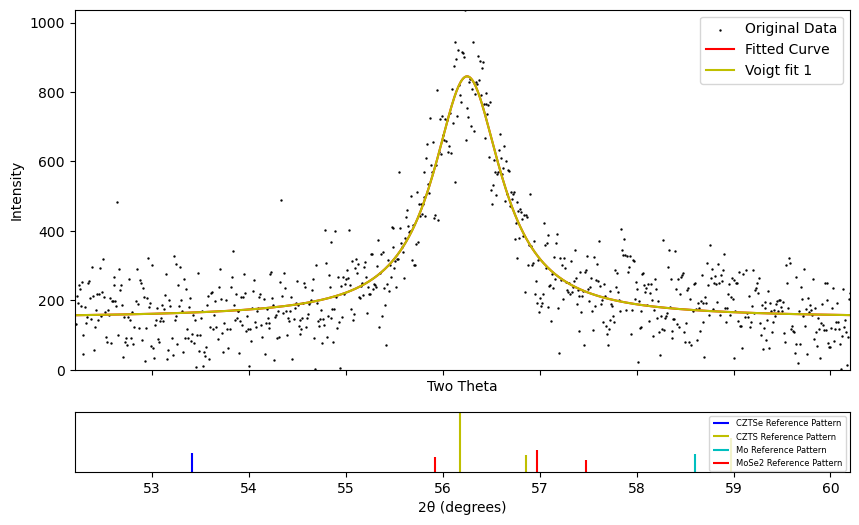

In [72]:
model = Model(psdVoigt)

xdata = df['two_theta'].values
ydata = df['baseline subtracted data'].values
peak_center = [56.2]
fit_range = (peak_center[0]-4, peak_center[0]+4)
fit_indices = np.where((xdata >= fit_range[0]) & (xdata <= fit_range[1]))[0] # Find the indices corresponding to the fit range
x_fit = xdata[fit_indices] # x fit data within specified range
y_fit = ydata[fit_indices] # y fit data within specified range

# Initial parameter guesses
guess_y0 = np.min(y_fit)
guess_A = np.max(y_fit) - np.min(y_fit)
guess_xc = x_fit[np.argmax(y_fit)]
guess_wL = 0.1  # Some initial value for the Lorentzian width
guess_wG = 0.1  # Some initial value for the Gaussian width
guess_xc = peak_center[0]  # Some initial value for the peak center

params = model.make_params(y0=guess_y0, A=guess_A, wL=guess_wL, wG=guess_wG, xc=guess_xc)

params['y0'].min = 0
params['y0'].max = 5000
params['A'].min = 0
params['A'].max = np.inf
params['wL'].min = 0
params['wG'].min = 0
params['xc'].min = peak_center[0]-0.2  # Lower bound for peak center
params['xc'].max = peak_center[0]+0.2  # Upper bound for peak center


# Fit the model to the data
result = model.fit(y_fit, params, x=x_fit)
# print(result.fit_report())

# Access fitted parameters
fitted_params = result.params
fit_params = {'Parameter': [], 'Value': []}
fit_stats = {'Statistic': [], 'Value': []}

# Store fitting parameters
for name, param in result.params.items():
    
    param_name = name[:-1] # Remove the numerical suffix from the parameter name
    
    # Append parameter name and value to the respective lists
    fit_params['Parameter'].append(param_name)
    fit_params[f'Value'].append(param.value)

fit_params['Value'].append(result.chisqr)
fit_params['Value'].append(result.redchi)
fit_params['Value'].append(result.aic)
fit_params['Value'].append(result.bic)

# print(fit_params)
# print(fit_stats)

fit_results_df = pd.DataFrame(columns=['y0', 'A', 'wL', 'wG', 'xc', 'Chi-square', 'Reduced Chi-square', 'Akaike info crit', 'Bayesian info crit'])
fit_results_df.loc[0] = fit_params['Value'] # Add Value_1 to the first row of the DataFrame

FWHM1 = FWHM(fit_results_df.loc[0][2], fit_results_df.loc[0][3])
mix1 = mixing_parameter(fit_results_df.loc[0][2],fit_results_df.loc[0][3], FWHM1)
int_breadth1 = integral_breadth(fit_results_df.loc[0][2],fit_results_df.loc[0][3], mix1)
domain_size1 = domain_size(fit_results_df.loc[0][4], int_breadth1)
strain1 = strain(fit_results_df.loc[0][4], int_breadth1)

fit_results_df.loc[0, 'FWHM'] = FWHM1
fit_results_df.loc[0, 'Mixing Parameter'] = mix1
fit_results_df.loc[0, 'Integral Breadth'] = int_breadth1
fit_results_df.loc[0, 'Domain Size'] = domain_size1
fit_results_df.loc[0, 'Strain'] = strain1

display(fit_results_df)

plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 1]})

ax1.scatter(df['two_theta'], df['baseline subtracted data'], c='k', s=0.5, label='Original Data')
ax1.set_ylabel("SQRT Intensity (counts)")
ax1.plot(x_fit, result.best_fit, 'r-', label='Fitted Curve')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value'][0], fit_params['Value'][1], fit_params['Value'][2], fit_params['Value'][3], fit_params['Value'][4]), color='y', label='Voigt fit 1')
ax1.set_xlabel('Two Theta')
ax1.set_ylabel('Intensity')
# ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(x_fit[0],x_fit[-1])
ax1.set_ylim(0,y_fit.max())
ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='6')
plt.show()

# Access fitted parameters
fitted_params = result.params

{'Parameter': ['y0', 'A', 'wL', 'wG', 'xc', 'A', 'wL', 'wG', 'xc'], 'Value_1': [850.5605976487286, 4.5134562753901264e-11, 0.007479119938420764, 0.10000000000000009, 27.20981769638401, 985411447.4552996, 2469702.8758278186, 6014.49948147211, 6050.600886041748], 'Value_2': [850.5605976487286, 6.400110047932728e-06, 0.0051397929220238225, 0.10000000000000009, 27.24810668352291, 985411447.4552996, 2469702.8758278186, 6014.49948147211, 6050.600886041748]}


,y0,A,wL,wG,xc,Chi-square,Reduced Chi-square,Akaike info crit,Bayesian info crit
0,850.560598,4.513456e-11,0.007479,0.1,27.209818,9.854114e+08,2.469703e+06,6014.499481,6050.600886
1,850.560598,6.400110e-06,0.005140,0.1,27.248107,9.854114e+08,2.469703e+06,6014.499481,6050.600886


<IPython.core.display.Javascript object>


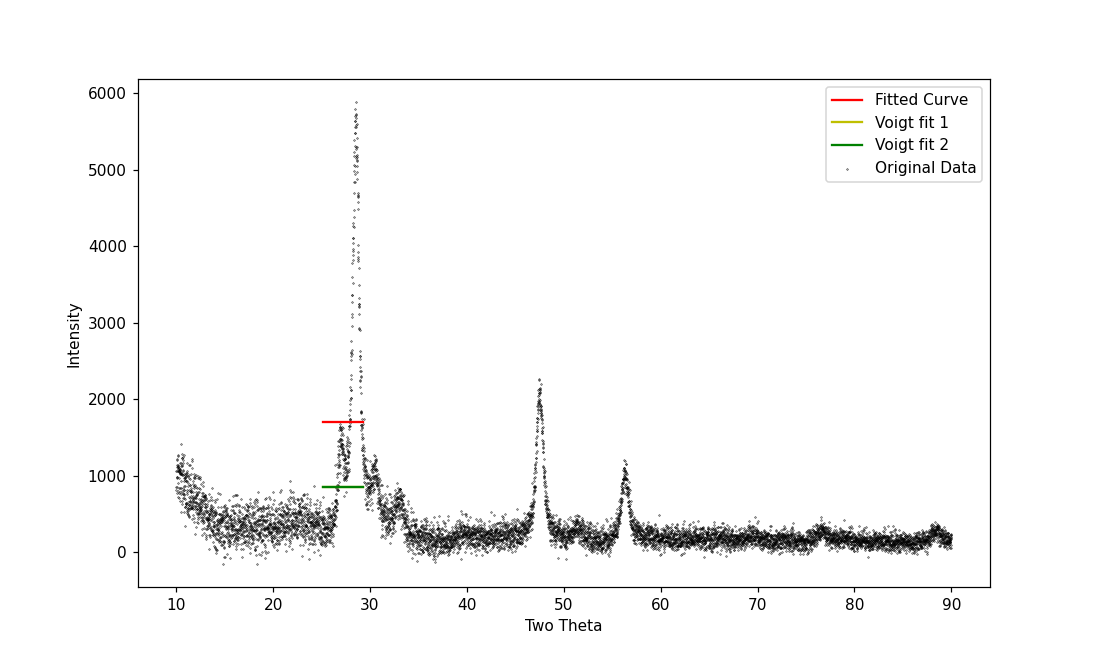

In [46]:
model = Model(_2psdVoigt)

xdata = df['two_theta'].values
ydata = df['baseline subtracted data'].values
peak_centers = [27.19,27.26]  # Adjust this value for your second peak
fit_range = (peak_centers[0]-2, peak_centers[1]+2)
fit_indices = np.where((xdata >= fit_range[0]) & (xdata <= fit_range[1]))[0] # Find the indices corresponding to the fit range
x_fit = xdata[fit_indices] # x fit data within specified range
y_fit = ydata[fit_indices] # y fit data within specified range

# Initial parameter guesses
guess_y01 = np.min(y_fit)
guess_A1 = np.max(y_fit)
guess_wL1 = 0.1  # Some initial value for the Lorentzian width
guess_wG1 = 0.1  # Some initial value for the Gaussian width
guess_xc1 = peak_centers[0]  # Some initial value for the peak center
guess_A2 = np.max(y_fit)
guess_wL2 = 0.1  # Some initial value for the Lorentzian width
guess_wG2 = 0.1  # Some initial value for the Gaussian width
guess_xc2 = peak_centers[1]  # Some initial value for the peak center


params = model.make_params(y01=guess_y01, A1=guess_A1, wL1=guess_wL1, wG1=guess_wG1, xc1=guess_xc1, A2=guess_A2, wL2=guess_wL2, wG2=guess_wG2, xc2=guess_xc2)

params['y01'].min = 0
params['y01'].max = 1000
params['A1'].min = 0
params['A1'].max = np.inf
params['A2'].min = 0
params['A2'].max = np.inf
params['wL1'].min = 0
params['wG1'].min = 0
params['wL2'].min = 0
params['wG2'].min = 0
params['xc1'].min = peak_centers[0]-0.1  # Lower bound for peak center
params['xc1'].max = peak_centers[0]+0.1  # Upper bound for peak center
params['xc2'].min = peak_centers[1]-0.1  # Lower bound for peak center
params['xc2'].max = peak_centers[1]+0.1  # Upper bound for peak center


# Fit the model to the data
result = model.fit(y_fit, params, x=x_fit)
# print(result.fit_report())

# Access fitted parameters
fitted_params = result.params
fit_params = {'Parameter': [], 'Value_1': [], 'Value_2': []}
fit_stats = {'Statistic': [], 'Value': []}

# Store fitting parameters
for name, param in result.params.items():
    # Check if the parameter belongs to fit 1 or fit 2
    if name.endswith('1'):
        fit_num = 1
    elif name.endswith('2'):
        fit_num = 2
    else:
        continue  # Skip non-fit parameters
    
    param_name = name[:-1] # Remove the numerical suffix from the parameter name
    
    # Append parameter name and value to the respective lists
    fit_params['Parameter'].append(param_name)
    fit_params[f'Value_{fit_num}'].append(param.value)

fit_params['Value_2'].insert(0, fit_params['Value_1'][0])
fit_params['Value_1'].append(result.chisqr)
fit_params['Value_1'].append(result.redchi)
fit_params['Value_1'].append(result.aic)
fit_params['Value_1'].append(result.bic)
fit_params['Value_2'].append(result.chisqr)
fit_params['Value_2'].append(result.redchi)
fit_params['Value_2'].append(result.aic)
fit_params['Value_2'].append(result.bic)
print(fit_params)
# print(fit_stats)

fit_results_df = pd.DataFrame(columns=['y0', 'A', 'wL', 'wG', 'xc', 'Chi-square', 'Reduced Chi-square', 'Akaike info crit', 'Bayesian info crit'])
fit_results_df.loc[0] = fit_params['Value_1'] # Add Value_1 to the first row of the DataFrame
fit_results_df.loc[1] = fit_params['Value_2'] # Add Value_2 to the first row of the DataFrame

FWHM1 = FWHM(fit_results_df.loc[0][2], fit_results_df.loc[0][3])
mix1 = mixing_parameter(fit_results_df.loc[0][2],fit_results_df.loc[0][3], FWHM1)
int_breadth1 = integral_breadth(fit_results_df.loc[0][2],fit_results_df.loc[0][3], mix1)
domain_size1 = domain_size(fit_results_df.loc[0][4], int_breadth1)
strain1 = strain(fit_results_df.loc[0][4], int_breadth1)
FWHM2 = FWHM(fit_results_df.loc[1][2], fit_results_df.loc[1][3])
mix2 = mixing_parameter(fit_results_df.loc[1][2],fit_results_df.loc[1][3], FWHM2)
int_breadth2 = integral_breadth(fit_results_df.loc[1][2],fit_results_df.loc[1][3], mix2)
domain_size2 = domain_size(fit_results_df.loc[1][4], int_breadth2)
strain2 = strain(fit_results_df.loc[1][4], int_breadth2)

fit_results_df.loc[0, 'FWHM'] = FWHM1
fit_results_df.loc[0, 'Mixing Parameter'] = mix1
fit_results_df.loc[0, 'Integral Breadth'] = int_breadth1
fit_results_df.loc[0, 'Domain Size'] = domain_size1
fit_results_df.loc[0, 'Strain'] = strain1

fit_results_df.loc[1, 'FWHM'] = FWHM2
fit_results_df.loc[1, 'Mixing Parameter'] = mix2
fit_results_df.loc[1, 'Integral Breadth'] = int_breadth2
fit_results_df.loc[1, 'Domain Size'] = domain_size2
fit_results_df.loc[1, 'Strain'] = strain2

display(fit_results_df)

plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 1]})

ax1.scatter(df['two_theta'], df['baseline subtracted data'], c='k', s=0.5, label='Original Data')
ax1.set_ylabel("SQRT Intensity (counts)")
ax1.plot(x_fit, result.best_fit, 'r-', label='Fitted Curve')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_1'][0], fit_params['Value_1'][1], fit_params['Value_1'][2], fit_params['Value_1'][3], fit_params['Value_1'][4]), color='y', label='Voigt fit 1')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_2'][0], fit_params['Value_2'][1], fit_params['Value_2'][2], fit_params['Value_2'][3], fit_params['Value_2'][4]), color='g', label='Voigt fit 2')
ax1.set_xlabel('Two Theta')
ax1.set_ylabel('Intensity')
# ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(x_fit[0],x_fit[-1])
ax1.set_ylim(0,y_fit.max())
ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='6')
plt.show()

{'Parameter': ['y0', 'A', 'wL', 'wG', 'xc', 'A', 'wL', 'wG', 'xc', 'A', 'wL', 'wG', 'xc'], 'Value_1': [71.36398253380605, 1481.0925621104036, 0.5582210404467531, 0.10000000000000009, 26.972935015113304, 14250924.66014984, 19310.1960164632, 7424.045951130143, 7484.124224603077], 'Value_2': [71.36398253380605, 8810.153041871115, 0.6958361701146922, 0.10000000000000009, 28.51417337321769, 14250924.66014984, 19310.1960164632, 7424.045951130143, 7484.124224603077], 'Value_3': [71.36398253380605, 1249.9437120895805, 0.8876659585034217, 0.10000000000000009, 30.48727474529282, 14250924.66014984, 19310.1960164632, 7424.045951130143, 7484.124224603077]}


C:\Users\w16025698\AppData\Local\Temp\ipykernel_21300\3847282925.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  FWHM1 = FWHM(fit_results_df.loc[0][2], fit_results_df.loc[0][3])
C:\Users\w16025698\AppData\Local\Temp\ipykernel_21300\3847282925.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mix1 = mixing_parameter(fit_results_df.loc[0][2],fit_results_df.loc[0][3], FWHM1)
C:\Users\w16025698\AppData\Local\Temp\ipykernel_21300\3847282925.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

,y0,A,wL,wG,xc,Chi-square,Reduced Chi-square,Akaike info crit,Bayesian info crit,FWHM,Mixing Parameter,Integral Breadth,Domain Size,Strain
0,71.363983,1481.092562,0.558221,0.1,26.972935,1.425092e+07,19310.196016,7424.045951,7484.124225,0.576467,0.976268,0.858569,18.452652,0.894980
1,71.363983,8810.153042,0.695836,0.1,28.514173,1.425092e+07,19310.196016,7424.045951,7484.124225,0.710773,0.984276,1.077504,14.752216,1.060121
2,71.363983,1249.943712,0.887666,0.1,30.487275,1.425092e+07,19310.196016,7424.045951,7484.124225,0.899677,0.990027,1.381498,11.558326,1.267373


<Figure size 640x480 with 0 Axes>

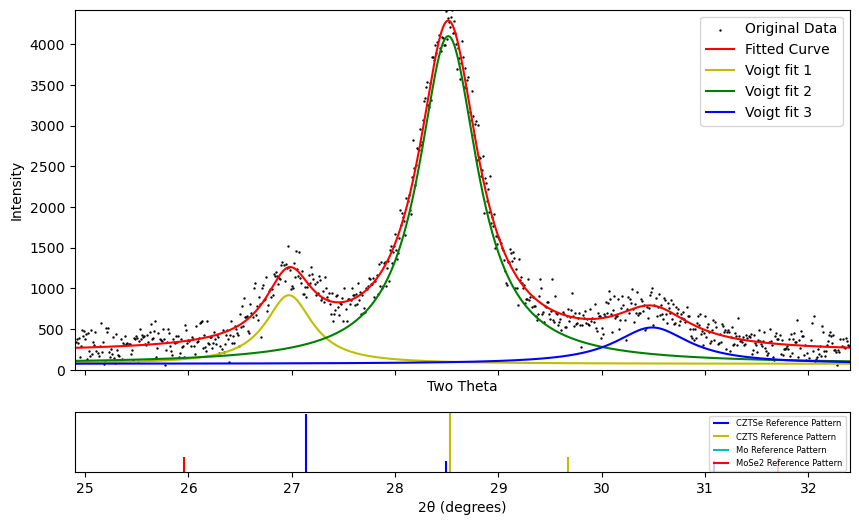

In [53]:
model = Model(_3psdVoigt)

xdata = df['two_theta'].values
ydata = df['baseline subtracted data'].values
# peak_centers = [45.09, 45.19, 45.3]  # Adjust this value for your second peak
peak_centers = [26.9,28.4, 30.4]
fit_range = (peak_centers[0]-2, peak_centers[2]+2)
fit_indices = np.where((xdata >= fit_range[0]) & (xdata <= fit_range[1]))[0] # Find the indices corresponding to the fit range
x_fit = xdata[fit_indices] # x fit data within specified range
y_fit = ydata[fit_indices] # y fit data within specified range

# Initial parameter guesses
guess_y01 = np.min(y_fit)
guess_A1 = np.max(y_fit) - np.min(y_fit)
guess_wL1 = 0.1  # Some initial value for the Lorentzian width
guess_wG1 = 0.1  # Some initial value for the Gaussian width
guess_xc1 = peak_centers[0]  # Some initial value for the peak center
guess_A2 = np.max(y_fit) - np.min(y_fit)
guess_wL2 = 0.1  # Some initial value for the Lorentzian width
guess_wG2 = 0.1  # Some initial value for the Gaussian width
guess_xc2 = peak_centers[1]  # Some initial value for the peak center
guess_A3 = np.max(y_fit) - np.min(y_fit)
guess_wL3 = 0.1  # Some initial value for the Lorentzian width
guess_wG3 = 0.1  # Some initial value for the Gaussian width
guess_xc3 = peak_centers[2]  # Some initial value for the peak center

params = model.make_params(y01=guess_y01, A1=guess_A1, wL1=guess_wL1, wG1=guess_wG1, xc1=guess_xc1, A2=guess_A2, wL2=guess_wL2, wG2=guess_wG2, xc2=guess_xc2, A3=guess_A3, wL3=guess_wL3, wG3=guess_wG3, xc3=guess_xc3)


params['y01'].min = 0
params['y01'].max = 1000
params['A1'].min = 0
params['A1'].max = np.inf
params['A2'].min = 0
params['A2'].max = np.inf
params['A3'].min = 0
params['A3'].max = np.inf
params['wL1'].min = 0
params['wG1'].min = 0
params['wL2'].min = 0
params['wG2'].min = 0
params['wL3'].min = 0
params['wG3'].min = 0
params['xc1'].min = peak_centers[0]-0.2  # Lower bound for peak center
params['xc1'].max = peak_centers[0]+0.2  # Upper bound for peak center
params['xc2'].min = peak_centers[1]-0.2  # Lower bound for peak center
params['xc2'].max = peak_centers[1]+0.2  # Upper bound for peak center
params['xc3'].min = peak_centers[2]-0.2  # Lower bound for peak center
params['xc3'].max = peak_centers[2]+0.2  # Upper bound for peak center

# Fit the model to the data
result = model.fit(y_fit, params, x=x_fit)
# print(result.fit_report())

# Access fitted parameters
fitted_params = result.params
fit_params = {'Parameter': [], 'Value_1': [], 'Value_2': [], 'Value_3': []}
fit_stats = {'Statistic': [], 'Value': []}

# Store fitting parameters
for name, param in result.params.items():
    # Check if the parameter belongs to fit 1 or fit 2 or fit 3
    if name.endswith('1'):
        fit_num = 1
    elif name.endswith('2'):
        fit_num = 2
    elif name.endswith('3'):
        fit_num = 3
    else:
        continue  # Skip non-fit parameters
    
    param_name = name[:-1] # Remove the numerical suffix from the parameter name
    
    # Append parameter name and value to the respective lists
    fit_params['Parameter'].append(param_name)
    fit_params[f'Value_{fit_num}'].append(param.value)

fit_params['Value_2'].insert(0, fit_params['Value_1'][0])
fit_params['Value_3'].insert(0, fit_params['Value_1'][0])
fit_params['Value_1'].append(result.chisqr)
fit_params['Value_1'].append(result.redchi)
fit_params['Value_1'].append(result.aic)
fit_params['Value_1'].append(result.bic)
fit_params['Value_2'].append(result.chisqr)
fit_params['Value_2'].append(result.redchi)
fit_params['Value_2'].append(result.aic)
fit_params['Value_2'].append(result.bic)
fit_params['Value_3'].append(result.chisqr)
fit_params['Value_3'].append(result.redchi)
fit_params['Value_3'].append(result.aic)
fit_params['Value_3'].append(result.bic)
print(fit_params)
# print(fit_stats)

fit_results_df = pd.DataFrame(columns=['y0', 'A', 'wL', 'wG', 'xc', 'Chi-square', 'Reduced Chi-square', 'Akaike info crit', 'Bayesian info crit'])
fit_results_df.loc[0] = fit_params['Value_1'] # Add Value_1 to the first row of the DataFrame
fit_results_df.loc[1] = fit_params['Value_2'] # Add Value_2 to the first row of the DataFrame
fit_results_df.loc[2] = fit_params['Value_3'] # Add Value_2 to the first row of the DataFrame

FWHM1 = FWHM(fit_results_df.loc[0][2], fit_results_df.loc[0][3])
mix1 = mixing_parameter(fit_results_df.loc[0][2],fit_results_df.loc[0][3], FWHM1)
int_breadth1 = integral_breadth(fit_results_df.loc[0][2],fit_results_df.loc[0][3], mix1)
domain_size1 = domain_size(fit_results_df.loc[0][4], int_breadth1)
strain1 = strain(fit_results_df.loc[0][4], int_breadth1)
FWHM2 = FWHM(fit_results_df.loc[1][2], fit_results_df.loc[1][3])
mix2 = mixing_parameter(fit_results_df.loc[1][2],fit_results_df.loc[1][3], FWHM2)
int_breadth2 = integral_breadth(fit_results_df.loc[1][2],fit_results_df.loc[1][3], mix2)
domain_size2 = domain_size(fit_results_df.loc[1][4], int_breadth2)
strain2 = strain(fit_results_df.loc[1][4], int_breadth2)
FWHM3 = FWHM(fit_results_df.loc[2][2], fit_results_df.loc[2][3])
mix3 = mixing_parameter(fit_results_df.loc[2][2],fit_results_df.loc[2][3], FWHM3)
int_breadth3 = integral_breadth(fit_results_df.loc[2][2],fit_results_df.loc[2][3], mix3)
domain_size3 = domain_size(fit_results_df.loc[2][4], int_breadth3)
strain3 = strain(fit_results_df.loc[2][4], int_breadth3)
fit_results_df.loc[0, 'FWHM'] = FWHM1
fit_results_df.loc[0, 'Mixing Parameter'] = mix1
fit_results_df.loc[0, 'Integral Breadth'] = int_breadth1
fit_results_df.loc[0, 'Domain Size'] = domain_size1
fit_results_df.loc[0, 'Strain'] = strain1

fit_results_df.loc[1, 'FWHM'] = FWHM2
fit_results_df.loc[1, 'Mixing Parameter'] = mix2
fit_results_df.loc[1, 'Integral Breadth'] = int_breadth2
fit_results_df.loc[1, 'Domain Size'] = domain_size2
fit_results_df.loc[1, 'Strain'] = strain2

fit_results_df.loc[2, 'FWHM'] = FWHM3
fit_results_df.loc[2, 'Mixing Parameter'] = mix3
fit_results_df.loc[2, 'Integral Breadth'] = int_breadth3
fit_results_df.loc[2, 'Domain Size'] = domain_size3
fit_results_df.loc[2, 'Strain'] = strain3

display(fit_results_df)

# Plot the sum of curves on the first subplot
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 1]})

ax1.scatter(df['two_theta'], df['baseline subtracted data'], c='k', s=0.5, label='Original Data')
ax1.set_ylabel("SQRT Intensity (counts)")
ax1.plot(x_fit, result.best_fit, 'r-', label='Fitted Curve')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_1'][0], fit_params['Value_1'][1], fit_params['Value_1'][2], fit_params['Value_1'][3], fit_params['Value_1'][4]), color='y', label='Voigt fit 1')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_2'][0], fit_params['Value_2'][1], fit_params['Value_2'][2], fit_params['Value_2'][3], fit_params['Value_2'][4]), color='g', label='Voigt fit 2')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_3'][0], fit_params['Value_3'][1], fit_params['Value_3'][2], fit_params['Value_3'][3], fit_params['Value_3'][4]), color='b', label='Voigt fit 3')
ax1.set_xlabel('Two Theta')
ax1.set_ylabel('Intensity')
# ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(x_fit[0],x_fit[-1])
ax1.set_ylim(0,y_fit.max())
ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='6')

plt.show()

{'Parameter': ['y0', 'A', 'wL', 'wG', 'xc', 'A', 'wL', 'wG', 'xc', 'A', 'wL', 'wG', 'xc', 'A', 'wL', 'wG', 'xc'], 'Value_1': [57.32632161529993, 1306.47523085832, 0.5194391328635284, 0.1, 26.95464659148326, 21999970.627042063, 15804.576599886539, 13639.18587548259, 13728.446679184868], 'Value_2': [57.32632161529993, 6476.910499134503, 0.706098644631975, 0.1, 28.498687213391108, 21999970.627042063, 15804.576599886539, 13639.18587548259, 13728.446679184868], 'Value_3': [57.32632161529993, 1592.6526144051072, 0.75284645322054, 0.1, 30.4658242256018, 21999970.627042063, 15804.576599886539, 13639.18587548259, 13728.446679184868], 'Value_4': [57.32632161529993, 948.1176604027335, 1.1945833559882313, 0.1, 32.90962856557535, 21999970.627042063, 15804.576599886539, 13639.18587548259, 13728.446679184868]}
8.607536143342287


,y0,A,wL,wG,xc,Chi-square,Reduced Chi-square,Akaike info crit,Bayesian info crit
0,57.326322,1306.475231,0.519439,0.1,26.954647,2.199997e+07,15804.5766,13639.185875,13728.446679
1,57.326322,6476.910499,0.706099,0.1,28.498687,2.199997e+07,15804.5766,13639.185875,13728.446679
2,57.326322,1592.652614,0.752846,0.1,30.465824,2.199997e+07,15804.5766,13639.185875,13728.446679
3,57.326322,948.117660,1.194583,0.1,32.909629,2.199997e+07,15804.5766,13639.185875,13728.446679


<IPython.core.display.Javascript object>


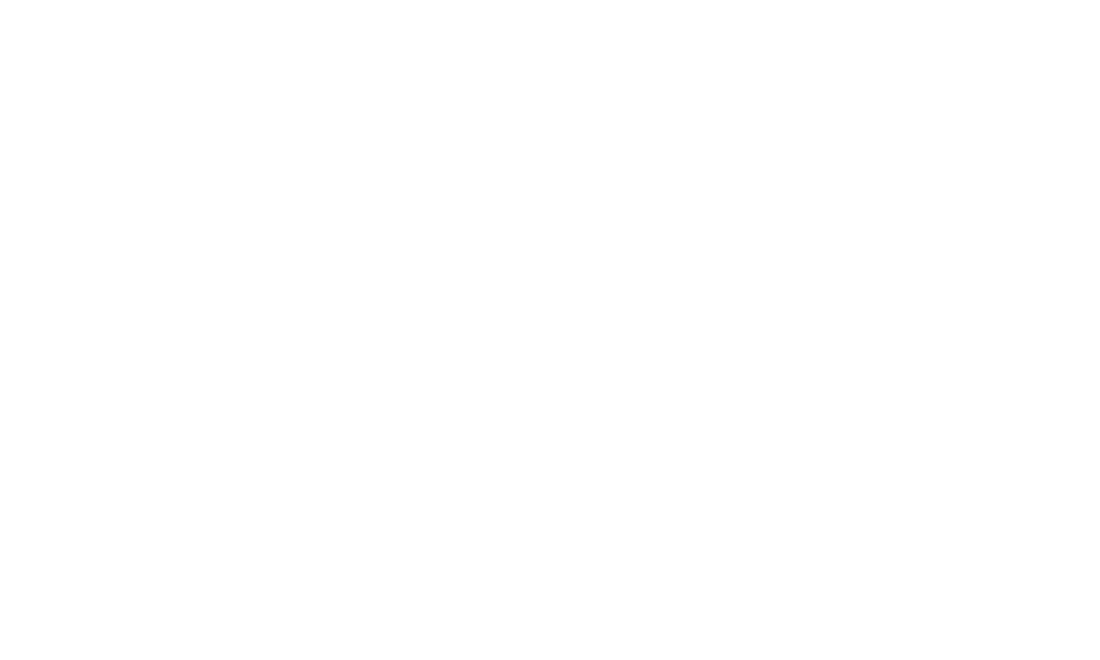

In [199]:
model = Model(_4psdVoigt)

xdata = df['two_theta'].values
ydata = df['baseline subtracted data'].values
peak_centers = [26.9,28.4, 30.4, 32.98]
# peak_centers = [26.9, 27.2, 27.34, 27.4]
fit_range = (peak_centers[0]-4, peak_centers[3]+4)
fit_indices = np.where((xdata >= fit_range[0]) & (xdata <= fit_range[1]))[0] # Find the indices corresponding to the fit range
x_fit = xdata[fit_indices] # x fit data within specified range
y_fit = ydata[fit_indices] # y fit data within specified range

# Initial parameter guesses
guess_y01 = np.min(y_fit)
guess_A1 = np.max(y_fit) - np.min(y_fit)
guess_wL1 = 0.1  # Some initial value for the Lorentzian width
guess_wG1 = 0.1  # Some initial value for the Gaussian width
guess_xc1 = peak_centers[0]  # Some initial value for the peak center
guess_A2 = np.max(y_fit) - np.min(y_fit)
guess_wL2 = 0.1  # Some initial value for the Lorentzian width
guess_wG2 = 0.1  # Some initial value for the Gaussian width
guess_xc2 = peak_centers[1]  # Some initial value for the peak center
guess_A3 = np.max(y_fit) - np.min(y_fit)
guess_wL3 = 0.1  # Some initial value for the Lorentzian width
guess_wG3 = 0.1  # Some initial value for the Gaussian width
guess_xc3 = peak_centers[2]  # Some initial value for the peak center
guess_A4 = np.max(y_fit) - np.min(y_fit)
guess_wL4 = 0.1  # Some initial value for the Lorentzian width
guess_wG4 = 0.1  # Some initial value for the Gaussian width
guess_xc4 = peak_centers[3]  # Some initial value for the peak center

params = model.make_params(y01=guess_y01, A1=guess_A1, wL1=guess_wL1, wG1=guess_wG1, xc1=guess_xc1, A2=guess_A2, wL2=guess_wL2, wG2=guess_wG2, xc2=guess_xc2, A3=guess_A3, wL3=guess_wL3, wG3=guess_wG3, xc3=guess_xc3, A4=guess_A4, wL4=guess_wL4, wG4=guess_wG4, xc4=guess_xc4)

# Fit the model to the data
result = model.fit(y_fit, params, x=x_fit)
# print(result.fit_report())

# Access fitted parameters
fitted_params = result.params
fit_params = {'Parameter': [], 'Value_1': [], 'Value_2': [], 'Value_3': [], 'Value_4': []}
fit_stats = {'Statistic': [], 'Value': []}

# Store fitting parameters
for name, param in result.params.items():
    # Check if the parameter belongs to fit 1 or fit 2 or fit 3
    if name.endswith('1'):
        fit_num = 1
    elif name.endswith('2'):
        fit_num = 2
    elif name.endswith('3'):
        fit_num = 3
    elif name.endswith('4'):
        fit_num = 4
    else:
        continue  # Skip non-fit parameters
    
    param_name = name[:-1] # Remove the numerical suffix from the parameter name
    
    # Append parameter name and value to the respective lists
    fit_params['Parameter'].append(param_name)
    fit_params[f'Value_{fit_num}'].append(param.value)

fit_params['Value_2'].insert(0, fit_params['Value_1'][0])
fit_params['Value_3'].insert(0, fit_params['Value_1'][0])
fit_params['Value_4'].insert(0, fit_params['Value_1'][0])
fit_params['Value_1'].append(result.chisqr)
fit_params['Value_1'].append(result.redchi)
fit_params['Value_1'].append(result.aic)
fit_params['Value_1'].append(result.bic)
fit_params['Value_2'].append(result.chisqr)
fit_params['Value_2'].append(result.redchi)
fit_params['Value_2'].append(result.aic)
fit_params['Value_2'].append(result.bic)
fit_params['Value_3'].append(result.chisqr)
fit_params['Value_3'].append(result.redchi)
fit_params['Value_3'].append(result.aic)
fit_params['Value_3'].append(result.bic)
fit_params['Value_4'].append(result.chisqr)
fit_params['Value_4'].append(result.redchi)
fit_params['Value_4'].append(result.aic)
fit_params['Value_4'].append(result.bic)
print(fit_params)
# print(fit_stats)

fit_results_df = pd.DataFrame(columns=['y0', 'A', 'wL', 'wG', 'xc', 'Chi-square', 'Reduced Chi-square', 'Akaike info crit', 'Bayesian info crit'])
fit_results_df.loc[0] = fit_params['Value_1'] # Add Value_1 to the first row of the DataFrame
fit_results_df.loc[1] = fit_params['Value_2'] # Add Value_2 to the first row of the DataFrame
fit_results_df.loc[2] = fit_params['Value_3'] # Add Value_3 to the first row of the DataFrame
fit_results_df.loc[3] = fit_params['Value_4'] # Add Value_4 to the first row of the DataFrame

FWHM1 = FWHM(fit_results_df.loc[0][2], fit_results_df.loc[0][3])
mix1 = mixing_parameter(fit_results_df.loc[0][2],fit_results_df.loc[0][3], FWHM1)
int_breadth1 = integral_breadth(fit_results_df.loc[0][2],fit_results_df.loc[0][3], mix1)
domain_size1 = domain_size(fit_results_df.loc[0][4], int_breadth1)
strain1 = strain(fit_results_df.loc[0][4], int_breadth1)
FWHM2 = FWHM(fit_results_df.loc[1][2], fit_results_df.loc[1][3])
mix2 = mixing_parameter(fit_results_df.loc[1][2],fit_results_df.loc[1][3], FWHM2)
int_breadth2 = integral_breadth(fit_results_df.loc[1][2],fit_results_df.loc[1][3], mix2)
domain_size2 = domain_size(fit_results_df.loc[1][4], int_breadth2)
strain2 = strain(fit_results_df.loc[1][4], int_breadth2)
FWHM3 = FWHM(fit_results_df.loc[2][2], fit_results_df.loc[2][3])
mix3 = mixing_parameter(fit_results_df.loc[2][2],fit_results_df.loc[2][3], FWHM3)
int_breadth3 = integral_breadth(fit_results_df.loc[2][2],fit_results_df.loc[2][3], mix3)
domain_size3 = domain_size(fit_results_df.loc[2][4], int_breadth3)
strain3 = strain(fit_results_df.loc[2][4], int_breadth3)
FWHM4 = FWHM(fit_results_df.loc[3][2], fit_results_df.loc[3][3])
mix4 = mixing_parameter(fit_results_df.loc[3][2],fit_results_df.loc[3][3], FWHM4)
int_breadth4 = integral_breadth(fit_results_df.loc[3][2],fit_results_df.loc[3][3], mix4)
domain_size4 = domain_size(fit_results_df.loc[3][4], int_breadth4)
strain4 = strain(fit_results_df.loc[3][4], int_breadth4)
fit_results_df.loc[0, 'FWHM'] = FWHM1
fit_results_df.loc[0, 'Mixing Parameter'] = mix1
fit_results_df.loc[0, 'Integral Breadth'] = int_breadth1
fit_results_df.loc[0, 'Domain Size'] = domain_size1
fit_results_df.loc[0, 'Strain'] = strain1

fit_results_df.loc[1, 'FWHM'] = FWHM2
fit_results_df.loc[1, 'Mixing Parameter'] = mix2
fit_results_df.loc[1, 'Integral Breadth'] = int_breadth2
fit_results_df.loc[1, 'Domain Size'] = domain_size2
fit_results_df.loc[1, 'Strain'] = strain2

fit_results_df.loc[2, 'FWHM'] = FWHM3
fit_results_df.loc[2, 'Mixing Parameter'] = mix3
fit_results_df.loc[2, 'Integral Breadth'] = int_breadth3
fit_results_df.loc[2, 'Domain Size'] = domain_size3
fit_results_df.loc[2, 'Strain'] = strain3

fit_results_df.loc[3, 'FWHM'] = FWHM4
fit_results_df.loc[3, 'Mixing Parameter'] = mix4
fit_results_df.loc[3, 'Integral Breadth'] = int_breadth4
fit_results_df.loc[3, 'Domain Size'] = domain_size4
fit_results_df.loc[3, 'Strain'] = strain4

print(domain_size4)

display(fit_results_df)

plt.clf()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 1]})

# Plot the sum of curves on the first subplot
ax1.scatter(df['two_theta'], df['baseline subtracted data'], c='k', s=0.5, label='Original Data')
ax1.set_ylabel("SQRT Intensity (counts)")
ax1.plot(x_fit, result.best_fit, 'r-', label='Fitted Curve')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_1'][0], fit_params['Value_1'][1], fit_params['Value_1'][2], fit_params['Value_1'][3], fit_params['Value_1'][4]), color='y', label='Voigt fit 1')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_2'][0], fit_params['Value_2'][1], fit_params['Value_2'][2], fit_params['Value_2'][3], fit_params['Value_2'][4]), color='g', label='Voigt fit 2')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_3'][0], fit_params['Value_3'][1], fit_params['Value_3'][2], fit_params['Value_3'][3], fit_params['Value_3'][4]), color='b', label='Voigt fit 3')
ax1.plot(x_fit, psdVoigt(x_fit, fit_params['Value_4'][0], fit_params['Value_4'][1], fit_params['Value_4'][2], fit_params['Value_4'][3], fit_params['Value_4'][4]), color='k', label='Voigt fit 4')
ax1.set_xlabel('Two Theta')
ax1.set_ylabel('Intensity')
# ax1.set_yticklabels([])  # Remove y-axis tick labels
ax1.set_xlim(x_fit[0],x_fit[-1])
ax1.set_ylim(0,y_fit.max())
ax1.legend()

# Plot the XRD reference pattern on the second subplot
# ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
# ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
# ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='6')
plt.show()

## Add Fit results to dataframe

In [60]:
# Full DataFrame of fit results
fit_results_all_df = pd.concat([fit_results_all_df, fit_results_df], ignore_index=True)
fit_results_all_df = fit_results_all_df.drop_duplicates(subset='xc', keep='last')
display(fit_results_all_df)

,y0,A,wL,wG,xc,Chi-square,Reduced Chi-square,Akaike info crit,Bayesian info crit,FWHM,Mixing Parameter,Integral Breadth,Domain Size,Strain
0,71.363983,1481.092562,0.558221,0.1,26.972935,1.425092e+07,19310.196016,7424.045951,7484.124225,0.576467,0.976268,0.858569,18.452652,0.894980
1,71.363983,8810.153042,0.695836,0.1,28.514173,1.425092e+07,19310.196016,7424.045951,7484.124225,0.710773,0.984276,1.077504,14.752216,1.060121
2,71.363983,1249.943712,0.887666,0.1,30.487275,1.425092e+07,19310.196016,7424.045951,7484.124225,0.899677,0.990027,1.381498,11.558326,1.267373
3,186.522757,3135.955177,0.721435,0.1,47.471035,6.504254e+06,8171.173156,7220.686914,7244.116218,0.735892,0.985305,1.118138,15.051414,0.635726
4,149.359307,1868.348590,0.854471,0.1,56.249695,5.440526e+06,6834.832246,7077.643881,7101.073186,0.866895,0.989292,1.328967,13.144533,0.621585


## Save Fit Results to an excel file

In [61]:
# Figure save settings
excel_filename = file_title + '_fit.xlsx'
excel_file_path = os.path.join(folder_path, excel_filename)

with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    fit_results_all_df.to_excel(writer, sheet_name='fit results', index=False)
    df.to_excel(writer, sheet_name='raw data', index=False)

## Figure Saving

<Figure size 640x480 with 0 Axes>

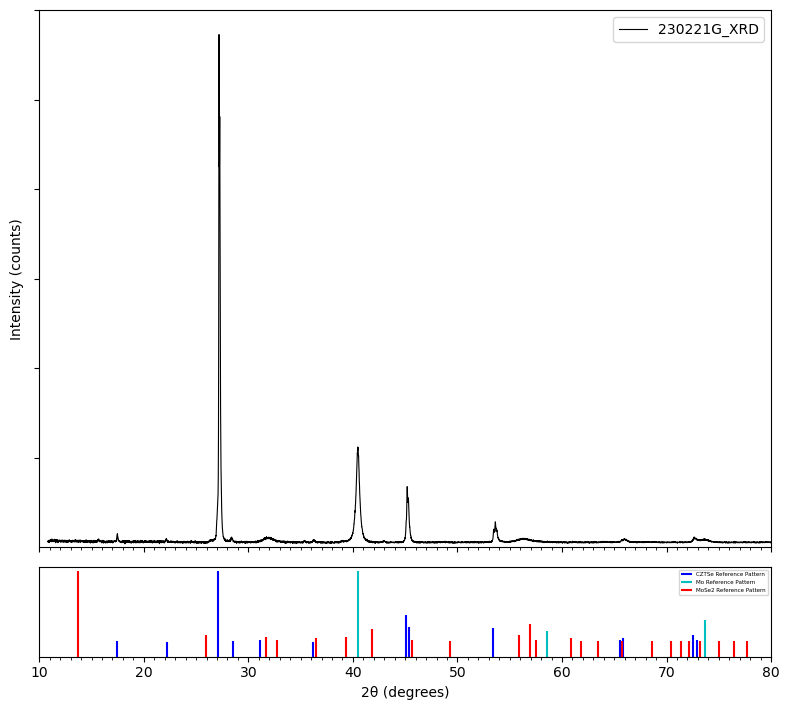

In [10]:
# Plot
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8), gridspec_kw={'height_ratios': [6, 1]})

# Plot the sum of curves on the first subplot
#ax1.plot(df['two_theta'], df['base_sub_intensity'], c='k', alpha=0.8, label=file_title)
ax1.plot(df['two_theta'], df['baseline subtracted data']+1000, c='k', linewidth=0.8, alpha=1, label=file_title)
ax1.set_ylabel("Intensity (counts)")
ax1.set_yticklabels([]) 
ax1.set_xlim(10,80)
ax1.set_ylim(10,120000)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.legend()

# Plot the XRD reference pattern on the second subplot
ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
# ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='4')

# Adjust spacing between subplots and set the height of the reference subplot
plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Save the plot as an image file
plt.savefig(os.path.join(folder_path, 'XRD Plots', file_title + '.png'), dpi=500)

## Figure Saving with fit
Finish this!!

In [ ]:
# Plot
plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Plot the sum of curves on the first subplot
#ax1.plot(df['two_theta'], df['base_sub_intensity'], c='k', alpha=0.8, label=file_title)
ax1.plot(df['two_theta'], df['baseline subtracted data'], c='k', alpha=0.8, label=file_title)
ax1.set_ylabel("Intensity (counts)")
ax1.set_yticklabels([]) 
ax1.set_xlim(10,80)
ax1.set_ylim(10,5000)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.legend()

# Plot the XRD reference pattern on the second subplot
# ax2.vlines(CZTSe_reference_df['Two Theta'], -20, CZTSe_reference_df['Intensity'], colors='b', label='CZTSe Reference Pattern')
ax2.vlines(CZTS_reference_df['Two Theta'], -20, CZTS_reference_df['Intensity'], colors='y', label='CZTS Reference Pattern')
ax2.vlines(Mo_reference_df['Two Theta'], -20, Mo_reference_df['Intensity'], colors='c', label='Mo Reference Pattern')
# ax2.vlines(MoSe2_reference_df['Two Theta'], -20, MoSe2_reference_df['Intensity'], colors='r', label='MoSe2 Reference Pattern')
ax2.set_xlabel("2θ (degrees)")
ax2.set_yticks([])
ax2.set_ylim(-20,105)
ax2.legend(loc='upper right', fontsize='4')

# Adjust spacing between subplots and set the height of the reference subplot
plt.subplots_adjust(hspace=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Save the plot as an image file
plt.savefig(os.path.join(folder_path, 'XRD Plots', file_title + '_fit.png'), dpi=500)